In [1]:
import warnings
from time import time

import joblib
import matplotlib.pyplot as plt
import pandas as pd
from joblib import Parallel, delayed
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

from tools.common_methods import print_results
warnings.simplefilter(action='ignore', category=FutureWarning)

Такі фічі як "Усього рекомендовано", "Допущено до конкурсу", "Середній пріоритет допущених", "Сер. Бал (на загальних підставах)" і т.п. стають відомими вже після того, як стає відомо і таргет змінну. Тому заради чистоти експерименту я вирішив спробувати навчити моделі лише на тих фічах, які відомі до фінальних результатів.

In [2]:
clear_df = pd.read_csv('../readyDatasets/preprocessed_dataframe.csv')

substrings_to_drop = ['загальних', 'допущен', 'рекомендован']

columns_to_drop = [col for col in clear_df.columns if
                   any(substring.lower() in col.lower() for substring in substrings_to_drop)]
clear_df.drop(columns=columns_to_drop, inplace=True)
x = clear_df.drop(columns='УСЬОГО')
y = clear_df['УСЬОГО']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=13)

In [3]:
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

MSE: 58.748339457424315 	R2 score: 0.9621389614097442


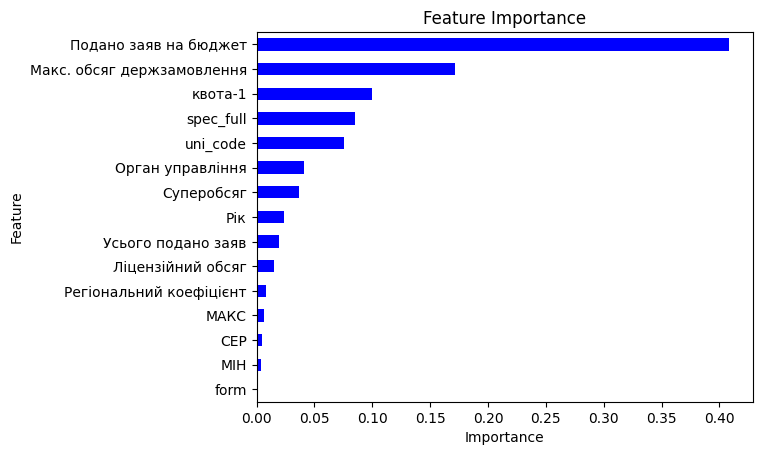

In [4]:
xgb_regressor = XGBRegressor(tree_method='exact', base_score=0.05, learning_rate=0.1, max_depth=5, n_estimators=5000, seed=1, validate_parameters=False)
xgb_regressor.fit(X_train_std, y_train)

y_pred = xgb_regressor.predict(X_test_std)
print_results(y_test, y_pred)

importances = pd.Series(xgb_regressor.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True, inplace=True)
importances.plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [12]:
results_df2 = pd.read_csv('../readyDatasets/xgb_known_features_iter_5000_estimators_01.csv')


def calculate_mse(rate, depth, eta, lambd, alpha, x_train_n_features_std, x_test_n_features_std, y_train, y_test):
    xgb_params = {'learning_rate': rate,
                  'max_depth': depth,
                  'n_estimators': 5000,
                  'eta': eta,
                  'gamma': 0,
                  'lambda': lambd,
                  'alpha': alpha,
                  'tree_method': 'exact',
                  'base_score': 0.1,
                  'validate_parameters': False,
                  'seed': 1}
    xgb_regressor = XGBRegressor(**xgb_params)
    xgb_regressor.fit(x_train_n_features_std, y_train)
    y_pred_xgb = xgb_regressor.predict(x_test_n_features_std)
    mse_xgb = mean_squared_error(y_test, y_pred_xgb)

    return mse_xgb, depth, rate, eta, lambd, alpha


def run_experiment(features):
    global results_df2
    n_best_features = importances.sort_values(ascending=False).head(features).keys()
    x_train_n_features = X_train.get(n_best_features)
    x_train_n_features_std = sc.fit_transform(x_train_n_features)

    x_test_n_features = X_test.get(n_best_features)
    x_test_n_features_std = sc.transform(x_test_n_features)

    best_depth = 0
    best_rate = 0
    best_eta = 0
    best_lambda = 0
    best_alpha = 0
    best_mse = 1000

    param_list = [
        (rate, depth, eta, lambd, alpha, x_train_n_features_std, x_test_n_features_std, y_train, y_test)
        for rate in [0.01, 0.05, 0.1, 0.15]
        for depth in [4, 5, 6, 7]
        for eta in [0.1 * i for i in range(1, 7)]
        for lambd in [0, 1, 2]
        for alpha in [0, 0.04, 0.1]]

    results = Parallel(n_jobs=-1, verbose=5)(delayed(calculate_mse)(*params) for params in param_list)

    for mse_gbr, depth, rate, eta, lambd, alpha in results:
        if mse_gbr < best_mse:
            best_mse = mse_gbr
            best_depth = depth
            best_rate = rate
            best_eta = eta
            best_lambda = lambd
            best_alpha = alpha

    results_df2 = results_df2.append({'Amount of features': features,
                                      'MSE': best_mse,
                                      'Rate': best_rate,
                                      'Depth': best_depth,
                                      'Eta': best_eta,
                                      'Gamma': 0,
                                      'Lambda': best_lambda,
                                      'Alpha': best_alpha},
                                     ignore_index=True)
    print(features, 'best mse:', best_mse, end=', ')

In [13]:
for features in range(4, 15):
    start = time()
    run_experiment(features)
    print('time for the round:', (int(time() - start) / 60), 'min')
    results_df2.to_csv('../readyDatasets/xgb_known_features_iter_5000_estimators_01.csv', index=False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 28.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 48.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 69.6min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 96.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


4 best mse: 82.53768935154753, time for the round: 96.75 min


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 17.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 33.7min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 56.8min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 82.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 112.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


5 best mse: 66.55310765546625, time for the round: 112.43333333333334 min


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 30.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 51.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 75.2min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 107.8min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


6 best mse: 64.81633416953586, time for the round: 107.75 min


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   45.0s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 40.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 68.5min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed: 99.9min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed: 135.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


7 best mse: 51.55728855136054, time for the round: 135.9 min


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   48.3s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 22.0min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed: 43.7min


KeyboardInterrupt: 

was tested with different base_score: 0.01, 0.1 and 0.5. The best result is:

In [5]:
n_best_features = importances.sort_values(ascending=False).head(7).keys()
x_train_n_features = X_train.get(n_best_features)
x_train_n_features_std = sc.fit_transform(x_train_n_features)

x_test_n_features = X_test.get(n_best_features)
x_test_n_features_std = sc.transform(x_test_n_features)

xgb_params = {'learning_rate': 0.1,
              'max_depth': 6,
              'n_estimators': 5000,
              'eta': 0.1,
              'gamma': 0,
              'lambda': 1,
              'alpha': 0,
              'tree_method': 'exact',
              'base_score': 0.5,
              'validate_parameters': False,
              'seed': 1}
xgb_regressor = XGBRegressor(**xgb_params)
xgb_regressor.fit(x_train_n_features_std, y_train)
y_pred_xgb = xgb_regressor.predict(x_test_n_features_std)
print_results(y_test, y_pred_xgb)

MSE: 50.15804638833622 	R2 score: 0.9676750739261849


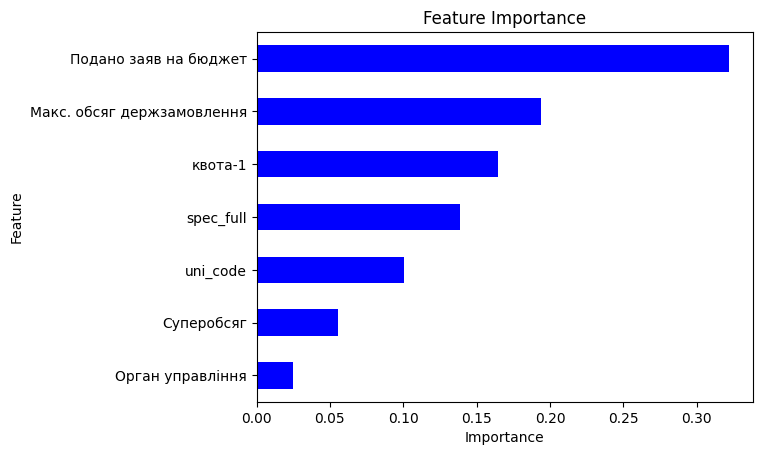

In [7]:
importances = pd.Series(xgb_regressor.feature_importances_, index=x_train_n_features.columns)
importances.sort_values(ascending=True, inplace=True)
importances.plot.barh(color='blue')
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

In [18]:
joblib.dump(xgb_regressor, '../saved_models/xgb_regressor_only_known_features.sav')

['../saved_models/xgb_regressor_only_known_features.sav']